# Importing Libraies

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from nltk.stem import PorterStemmer
import time
import matplotlib.pyplot as plt
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kritarth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kritarth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kritarth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Exploration
## dataset link : https://data.world/crowdflower/apple-twitter-sentiment

In [3]:
df = pd.read_csv('apple_twitter_sentiment_dfe.csv',usecols=['sentiment','text'])
df.sample(5)

,sentiment,text
3267,1,.@Apple there is still not a suicide note temp...
2665,3,Explore all the Apple rumours for 2015 http://...
141,3,Barclay's #Apple Analyst Joins The Crowd And I...
704,3,RT @Stuff_SG: The rumoured @oppo R8207 looks v...
1935,5,'After School' app gets pulled by @apple ... I...


In [4]:
sentiment_map = {0:'negative',1:'nuetral',2:'positive'}
# 1 negative 3 nuetral 5 positive ====> 0 negative 1 nuetral 2 positive
df.drop(df[df['sentiment']=='not_relevant'].index, inplace = True) 
df['sentiment'] = df['sentiment'].apply(lambda x:(int(x)-1)//2)
df.sample(10)

,sentiment,text
3246,1,#Apple PT Raised to $135.00 #AAPL http://t.co/...
3631,1,Apple antitrust hearing will continue despite ...
2430,0,Apple Could Face iPhone 6 Shortages Next Year ...
1224,0,@engadget why are apple users surprised? @appl...
855,1,@GregBurke85 Just wait until @Apple Inquisitio...
3873,1,Apple Is Warming Up To Social Media: Apple is ...
2658,1,#AAPL:iPhone 7 Rumors: Might be Called iPhone ...
2466,1,Mark Zuckerberg's Newest Frenemy: Tim Cook $AA...
776,0,GOSH DARNIT @Apple I DONT KNOW WHAT THE CLOUD IS
1346,1,How many @Apple products does it take to write...


In [5]:
df.dtypes

sentiment     int64
text         object
dtype: object

In [6]:
print("Negative : {}".format((df.sentiment==0).sum()))
print("Nuetral : {}".format((df.sentiment==1).sum()))
print("Positive : {}".format((df.sentiment==2).sum()))

Negative : 1219
Nuetral : 2162
Positive : 423


## Downsampling is performed to remove imbalance

In [7]:
def downsample(df,col='sentiment'):
    nmin = df[col].value_counts().min()
    return (df.groupby(col).apply(lambda x: x.sample(nmin)).reset_index(drop=True))

In [8]:
df = downsample(df)
print("Negative : {}".format((df.sentiment==0).sum()))
print("Nuetral : {}".format((df.sentiment==1).sum()))
print("Positive : {}".format((df.sentiment==2).sum()))
df = df.sample(frac=1).reset_index(drop=True)
df.sample(5)

Negative : 423
Nuetral : 423
Positive : 423


,sentiment,text
1213,2,Goodbye graphics problems. Thank you @apple fo...
648,2,.@apple has a 40% market share of UK smartphon...
583,2,Finally! @Apple Gives #India the Attention it ...
39,0,"Is it just me, who feels #Yosemite eats more b..."
125,0,Why I Hate #Apple. #aapl http://t.co/inkCjYw0Lq


# Preprocessing

In [9]:
def lower_text(input_text):
    return input_text.lower()

def remove_punctuations(input_text):
    input_text = re.sub(r'[^\w\s@#]', '', input_text)
    return input_text

def remove_at(input_text):
    input_text = re.sub(r'\@\w+$','',input_text)
    input_text = re.sub(r'\@\w+(\s)','',input_text)
    return input_text

def remove_url(input_text):
    input_text = re.sub(r'https?\S+(\s)','',input_text)
    input_text = re.sub(r'pic?\S+(\s)','',input_text)
    input_text = re.sub(r'https?\S+$','',input_text)
    input_text = re.sub(r'pic?\S+$','',input_text)
    return input_text

def extract_hashtags(input_text):
    hashtags1 = re.findall('[#$]\w+\s',input_text)
    hashtags2 = re.findall('[#$]\w+$',input_text)
    hashtags = hashtags1 + hashtags2
    for i in range(len(hashtags)):
        hashtags[i] = hashtags[i].strip()[1:]
    return ' '.join(hashtags)
    
def remove_hashtags(input_text):
    input_text = re.sub('[#$]\w+\s',' ',input_text)
    return re.sub('[#$]\w+$',' ',input_text)

def remove_encoded_words(input_text):
    return re.sub(r'[^\x00-\x7F]+',' ', input_text)

def remove_noise(input_text):
    input_text = re.sub(r'^rt',' ',input_text)
    input_text = re.sub(r'\W',' ',input_text)
    input_text = re.sub(r'\d',' ',input_text)
    input_text = re.sub(r'\s+',' ',input_text)
    return input_text

In [10]:
def clean_text(input_text):
    sentences = sent_tokenize(input_text)
    for i in range(len(sentences)):
        sentences[i] = lower_text(sentences[i])
        sentences[i] = remove_punctuations(sentences[i])
        sentences[i] = remove_at(sentences[i])
        sentences[i] = remove_url(sentences[i])
        sentences[i] = remove_hashtags(sentences[i])
        sentences[i] = remove_encoded_words(sentences[i])
        sentences[i] = remove_noise(sentences[i])
        words = word_tokenize(sentences[i])
        new = []
        for word in words:
            if word not in stopwords.words('english'):
                new.append(word)
        sentences[i] = ' '.join(new)
    return sentences

In [11]:
def lematization(sentences):
    lem = WordNetLemmatizer()
    for i in range(len(sentences)):
        words = nltk.word_tokenize(sentences[i])
        words = [lem.lemmatize(word,pos='v') for word in words]
        sentences[i] = ' '.join(words)
    return sentences

def stemming(sentences):
    stemmer = PorterStemmer()
    for i in range(len(sentences)):
        words = nltk.word_tokenize(sentences[i])
        words = [stemmer.stem(word) for word in words]
        sentences[i] = ' '.join(words)
    return sentences

def spell_correction(sentences):
    lem = WordNetLemmatizer()
    for i in range(len(sentences)):
        words = nltk.word_tokenize(sentences[i])
        words = [str(TextBlob(word).correct()) for word in words]
        words = [lem.lemmatize(word,pos='v') for word in words]
        sentences[i] = ' '.join(words)
    return sentences

In [12]:
def technique1(input_text):
    sentences = clean_text(input_text)
    sentences = lematization(sentences)
    return ' '.join(sentences)

def technique2(input_text):
    sentences = clean_text(input_text)
    sentences = stemming(sentences)
    return ' '.join(sentences)

def technique3(input_text):
    sentences = clean_text(input_text)
    sentences = spell_correction(sentences)
    return ' '.join(sentences)

In [13]:
time_taken = []
start = time.time()
df['text_lematized'] = df['text'].apply(technique1)
time_taken.append(time.time()-start)
print('Technique 1 completed')
start = time.time()
df['text_stemmed'] = df['text'].apply(technique2)
time_taken.append(time.time()-start)
print('Technique 2 completed')
# Spell check takes very long
'''
start = time.time()
df['text_spell_checked'] = df['text'].apply(technique3)
time_taken.append(time.time()-start)
print('Technique 3 completed')
'''
df['hashtags'] = df['text'].apply(extract_hashtags)
df.sample(5)

Technique 1 completed
Technique 2 completed


,sentiment,text,text_lematized,text_stemmed,hashtags
275,1,Imagine a world without cracked #iPhone screen...,imagine world without crack screen patent drop...,imagin world without crack screen patent drop ...,iPhone
223,2,Great @apple my phone number is so accurate ht...,great phone number accurate,great phone number accur,
937,1,@iamrayuko @Apple because you know you don't w...,know dont want none,know dont want none,
311,2,.@codeorg it looks like @Apple is offering a f...,look like offer free course one program thing...,look like offer free cours one program thing ...,HourOfCode
1135,1,RT @JPDesloges: Apple to Support a New Franchi...,apple support new franchise ios store india aapl,appl support new franchis io store india aapl,AAPL aapl


# View Random Tweet

In [14]:
def random_tweet(df):
    i = random.randint(0,df.shape[0])
    print("Tweet : {}".format(df['text'][i]))
    print("\nSentiment : {}".format(sentiment_map[df['sentiment'][i]])) 
    print("\nLematized Tweet : {}".format(df['text_lematized'][i]))
    print("\nStemmed Tweet : {}".format(df['text_stemmed'][i]))
    print("\nHashtags : {}".format(extract_hashtags(df['text'][i])))

In [15]:
random_tweet(df)

Tweet : RT @schreier: It makes you smarter.  Elevate is @apple app of the year!  Congratulations @jessepickard and team.  http://t.co/r0cgmthoCC

Sentiment : positive

Lematized Tweet : make smarter elevate app year congratulations team 

Stemmed Tweet : make smarter elev app year congratul team 

Hashtags : 


# Comparision of techniques based on time taken

<BarContainer object of 2 artists>

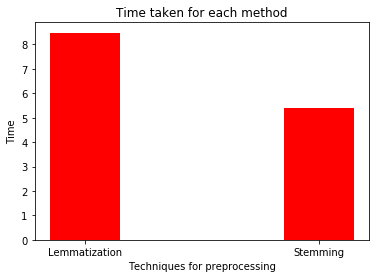

In [16]:
plt.title('Time taken for each method')
plt.ylabel('Time')
plt.xlabel('Techniques for preprocessing')
plt.bar(['Lemmatization','Stemming'],time_taken,width=0.3,color='r')

# Training Bayes and SVM models
## Stemming takes less time hence technique 2 is used

In [17]:
train_percent = 0.90

while True:
    choice = int(input('Enter 0 for Stemming and 1 for Lemmatization : '))
    if choice==0:
        X = list(df['text_stemmed'])
        break
    elif choice==1:
        X = list(df['text_lematized'])
        break
    else:
        continue

Y = list(df['sentiment'])
X_train = X[:int(train_percent*len(X))]
Y_train = Y[:int(train_percent*len(X))]
X_test = X[int(train_percent*len(X)):]
Y_test = Y[int(train_percent*len(X)):]

Enter 0 for Stemming and 1 for Lemmatization : 0


In [18]:
def confusionMatrix(Y_test,Y_pred):
    cm = confusion_matrix(Y_test, Y_pred,labels=[0,1,2],normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['negative','nuetral','positive'])
    disp.plot(cmap='Blues',xticks_rotation='vertical')

In [19]:
model_bayes_text = make_pipeline(TfidfVectorizer(),MultinomialNB())

model_bayes_text.fit(X_train,Y_train)

Y_pred = model_bayes_text.predict(X_test)

Accuracy : 0.5984251968503937


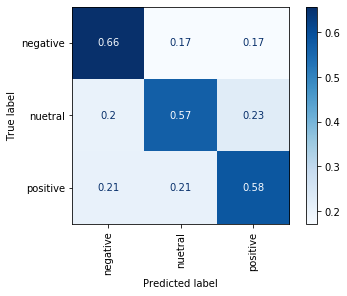

In [20]:
print("Accuracy : {}".format(model_bayes_text.score(X_test,Y_test)))
confusionMatrix(Y_test,Y_pred)

In [21]:
def predict_sentiment(model,X,alpha=0.3):
    Y_pred_text = model.predict_proba(X)
    for i in range(len(X)):
        hashtags_test = extract_hashtags(X[i]).strip()
        if hashtags_test!='':
            Y_pred_text[i] = (1-alpha)*Y_pred_text[i]+alpha*model.predict_proba(hashtags_test)
        score = Y_pred_text[i][1]+2*Y_pred_text[i][2]
    return np.argmax(Y_pred_text,axis=1) 

def accuracy(Y_test,Y_pred):
    score = 0
    for i in range(len(Y_test)):
        if Y_test[i]==Y_pred[i]:
            score+=1
    return float(score)/len(Y_test)

Accuracy : 0.5984251968503937


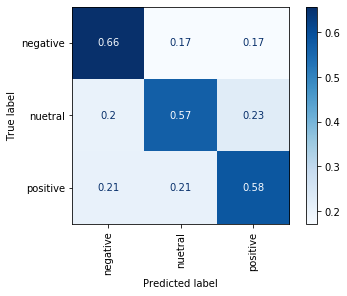

In [22]:
Y_pred = predict_sentiment(model_bayes_text,X_test)
print("Accuracy : {}".format(accuracy(Y_test,Y_pred)))
confusionMatrix(Y_test,Y_pred)

In [22]:
predict_sentiment(model_bayes_text,[technique2(input('Enter tweet : '))])

Enter tweet : Good product #average


[1]

In [26]:
model_svm_text = make_pipeline(TfidfVectorizer(),SVC(probability=True))

model_svm_text.fit(X_train,Y_train)

Y_pred = model_svm_text.predict(X_test)

Accuracy : 0.5905511811023622


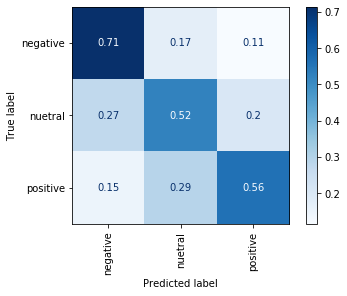

In [27]:
print("Accuracy : {}".format(model_svm_text.score(X_test,Y_test)))
confusionMatrix(Y_test,Y_pred)

Accuracy : 0.5905511811023622


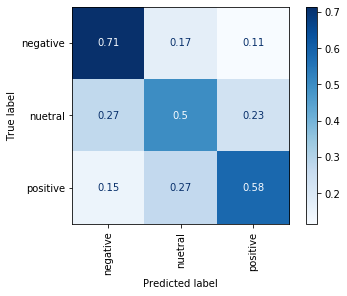

In [28]:
Y_pred = predict_sentiment(model_svm_text,X_test)
print("Accuracy : {}".format(accuracy(Y_test,Y_pred)))
confusionMatrix(Y_test,Y_pred)